In [ ]:
#code to look at the orientation of a TC on a plan view map, with wind barbs, topography, and pressure contours
#I have the location of a cross section and point of interest, since it is important to know where the storm and winds are relative to the mtns at a given time (orographic enhancement)
#Planning to update this sometime with locations of multiple cross sections along a given stretch, which I will average (average cross section, reduce noise)
#plot with animation

In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.cbook as cbook
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

import pandas as pd
import xarray as xr
import numpy as np
import math
from numpy import *
from pylab import *
import pygrib
import pyproj
import mpl_toolkits
from mpl_toolkits import mplot3d

from siphon.catalog import TDSCatalog
from siphon.http_util import session_manager
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
from netCDF4 import Dataset
import metpy as metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.units import units
from metpy.plots import add_metpy_logo, add_timestamp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
import pint

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy import config
from cartopy import feature as cfeat
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import glob

132
/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d02_2004-09-13_12:00:00
WRF valid time:  2004-09-16_15
52.1985969543457 knot


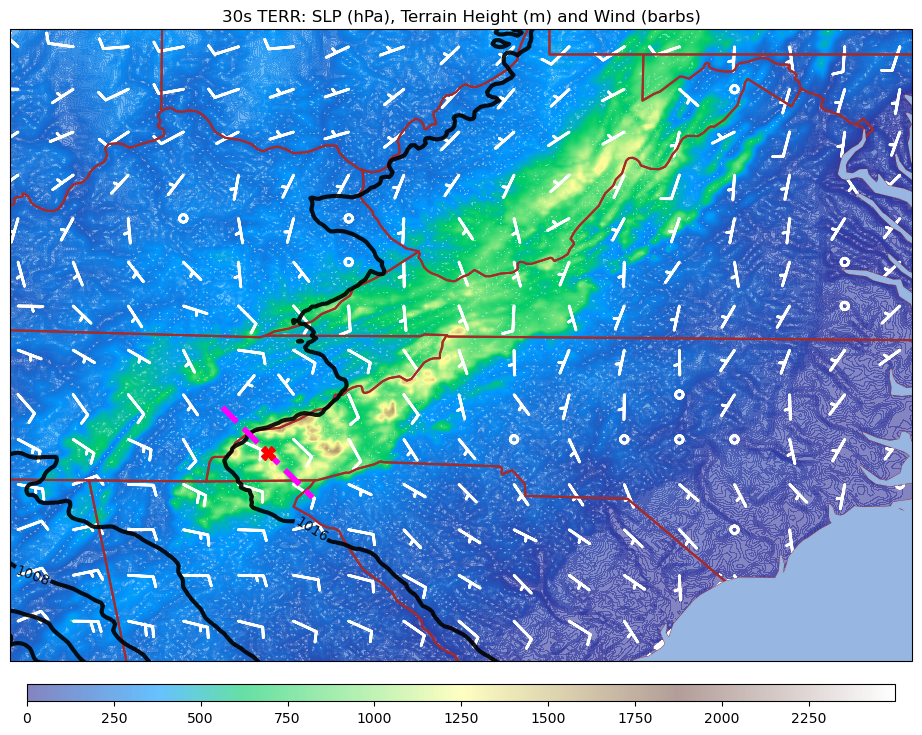

WRF valid time:  2004-09-16_16
56.74805450439453 knot


KeyboardInterrupt: 

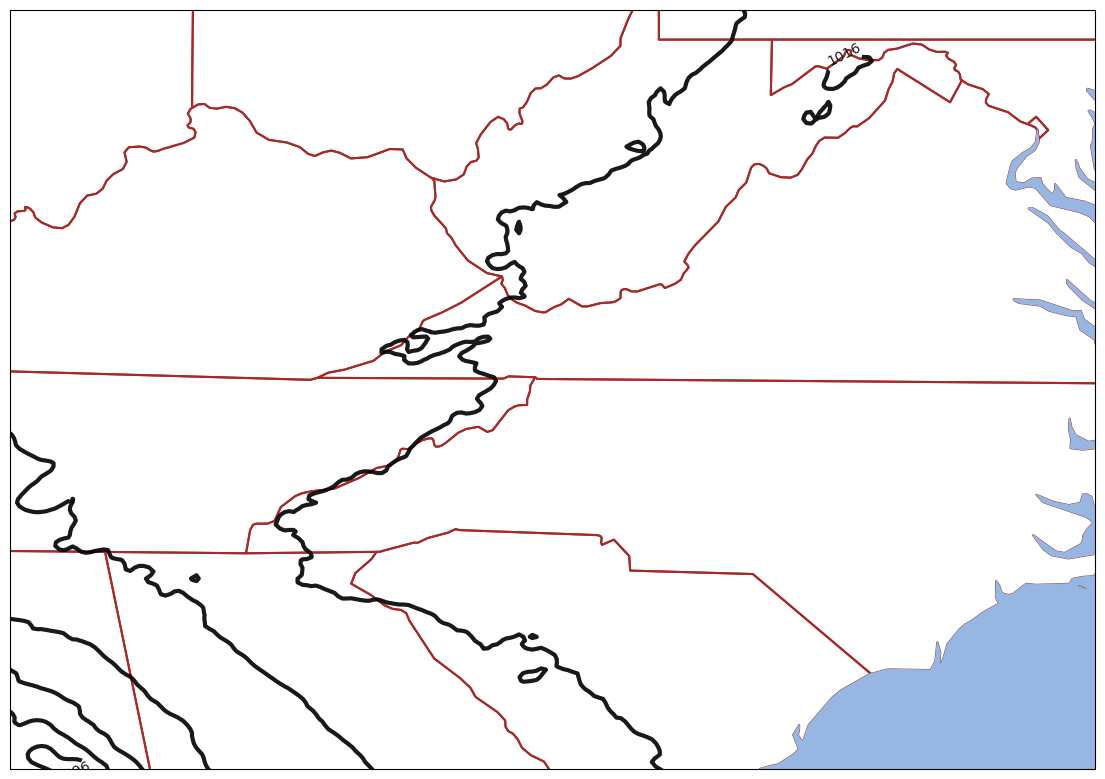

In [8]:
# SPECIFY Data File
#want these for when Ivan is crossing/interacting with the appalachians, and need to use domain 2 for SLP accuraccy. 
#look at 09/17 00Z (index: 28) - index 34 (09/18 06z) (indicies for 3 hourly files)

#Set up for saving graphics files, create directory for plots, if needed
plotsdir = '/home/jupyter-amsinnin@ncsu.edu/Ivan/Ivan_ctrl_plots/winds_hires'
if os.path.isdir(plotsdir) != 1:
    subprocess.call(["mkdir","-p",plotsdir])
os.chdir(plotsdir)

# Set directory where wrfout files reside, and list the files for processing.  Set up for a directory with only wrfout files.

datafiles = (glob.glob("/scratch/amanda/ivan_ensembles/ens1_ivan_new_w_epssm/hourly_d02*")) #hourly output files
datafiles.sort()
numfiles=len(datafiles)
print(numfiles)
print(datafiles[0])

ivan_slp=[]
ivan_rain=[]
ivan_dbz=[]
ivan_runoff=[]
filetimes=[]
for j in range(75,110):
    ncfile = Dataset(datafiles[j])
    Time=wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime)
    #print(ncfile)
    # Get all the variables we need
    runoff = ncfile.variables["SFROFF"][0,:,:] #get surface runoff
    z = getvar(ncfile, "z")
    p = getvar(ncfile, "pressure")
    slp = getvar(ncfile, "slp")
    rainc = getvar(ncfile, "RAINC")
    rainnc = getvar(ncfile, "RAINNC")
    tk = getvar(ncfile, "tk")
    ua = getvar(ncfile, "ua", units="kt")
    va = getvar(ncfile, "va", units="kt")
    wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]
    lat = getvar(ncfile, 'lat')
    lon = getvar(ncfile, 'lon')
    hires_terr= ncfile.variables["HGT"][0,:,:] #terrain height for the 30s terr resolution
    runoff = ncfile.variables["SFROFF"][0,:,:]
    
    
    ureg = pint.UnitRegistry()
    u_10 = units.Quantity(ncfile.variables['U10'][0,:,:], 'm/s')
    v_10 = units.Quantity(ncfile.variables['V10'][0,:,:], 'm/s')
    u_10_kts = u_10.to(ureg.knot)
    v_10_kts = v_10.to(ureg.knot)
    mag_wind_10 = mpcalc.wind_speed(u_10, v_10)
    #dir_wind_10 =mpcalc.wind_direction(u_10,v_10)
    print(np.max(u_10_kts))
    hires_terr = np.where(hires_terr < 0, np.nan, hires_terr)
    
    #print('runoff shape',np.shape(runoff))
    raintot = (rainc + rainnc)*0.0393701 #in inches
    
    
    ivan_rain.append(raintot)
    ivan_runoff.append(runoff)
    filetimes.append(filetime)
    #print('list of filetimes',filetime)
    
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",facecolor="none", name="admin_1_states_provinces_shp")
    # Get the latitude and longitude points
    lats, lons = latlon_coords(slp)
    
    # Smooth the sea level pressure since it tends to be noisy near complex terrain
    smooth_slp = smooth2d(slp, 3, cenweight=4)
    #smooth_slp_2d = smooth2d(slp, 3, cenweight=4)
    ivan_slp.append(smooth_slp)
    #print(np.shape(smooth_slp))
    #print(lats,lons)

    plotproj = crs.PlateCarree()#(central_longitude=-85., central_latitude=30.,standard_parallels=[30, 60])
    fig = plt.figure(figsize=(14,10))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-86.5, -76.5, 33, 40],crs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.5, edgecolor='brown')
    ax.coastlines('50m', linewidth=0.4)
    
    # Add contours
    rain_levels = np.arange(1, 25, 0.5)
    pmsl_levels = np.arange(900, 1060, 4)
    hgt_levels = np.arange(0, 2500, 2)
    contours = plt.contour(to_np(lon), to_np(lat), to_np(smooth_slp), levels=pmsl_levels, colors="black", alpha= .9, linewidths = 3,linestyles='solid',transform=crs.PlateCarree())
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i") 
    #
    sea_mask = NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeat.COLORS['water'])
    ax.add_feature(sea_mask, zorder=2)
    
    hgt_contours = plt.contourf(to_np(lons), to_np(lats), to_np(hires_terr),levels = hgt_levels,
                             cmap=get_cmap("terrain"),norm=Normalize(0,2500), vmin=0, vmax=2500, alpha=.6,transform=crs.PlateCarree())
    plt.colorbar(hgt_contours, ax=ax, orientation="horizontal", pad=.03, shrink=.8, aspect=50)

    #wind barbs
    ax.barbs(lon[::15,::15], lat[::15,::15], u_10_kts[::15, ::15], v_10_kts[::15, ::15], length = 6, transform=crs.PlateCarree(),color='white', linewidth=2.0, sizes=dict(spacing=0.3))
    
    #lat/lon for the central interest point
    pt_lat = 35.3089 
    pt_lon = -83.6443
    
    #calculate lats/lons of cross section
    start_lat = pt_lat +.50 #start lat for cross section #start lat for cross section... orig .25, extended to see more of slope
    end_lat = pt_lat -.50 #end lat for cross section
    start_lon = pt_lon -.50
    end_lon= pt_lon + .50
    # Plot the black line representing the cross section
    ax.plot([start_lon, end_lon], [start_lat, end_lat], transform=ccrs.PlateCarree(), color='magenta', linestyle= 'dashed',linewidth=4)
    
    plt.plot(-83.6443, 35.3089 , marker= 'X', color='red', markersize=10) #box culvert pt location
    #plt.plot(-82.2652, 35.7650 , marker= 'X', color='red', markersize=10)
    # Set the extent of the map to include the cross section
    #ax.set_extent([start_lon - 0.5, end_lon + 0.5, start_lat - 0.5, end_lat + 0.5])
    
    plt.title("30s TERR: SLP (hPa), Terrain Height (m) and Wind (barbs)")
    
    # Create separate plot file and save as .png, then show and close
    plt.savefig('winds_hires_'+filetime+'.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()


In [ ]:
#animation for hi_res terr ivan

# Set up a figure and axis for the animation
fig, ax = plt.subplots()

# Get a list of all the saved figures in the current directory
fig_files = glob.glob('/home/jupyter-amsinnin@ncsu.edu/Ivan/Ivan_ctrl_plots/winds_hires/*.png')
fig_files.sort()
# Define the animation function
def animate(i):
    # Clear the axis
    ax.clear()

    # Load the i-th figure from the list of saved figures
    fig_file = fig_files[i]
    img = plt.imread(fig_file)

    # Display the image on the axis
    ax.imshow(img)

    # Set the title of the axis to the file name of the current figure
    ax.set_title(os.path.basename(fig_file))

# Create the animation using the FuncAnimation class
ani = FuncAnimation(fig, animate, frames=len(fig_files), interval=1000)

# Display the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

ani.save("animation_slp_winds.gif", writer=PillowWriter(fps=5))
